In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from keras import Input
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense, LSTM, GRU
from keras.layers import Conv1D
from keras.layers import MaxPooling1D 

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [3]:
df = pd.read_csv(csv_path)
# slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

In [5]:
df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.20,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.50,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.60,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.20,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420521,1002.18,-0.98,272.01,-5.36,72.00,5.69,4.09,1.59,2.54,4.08,1280.70,0.87,1.36,190.6
420527,1001.40,-1.40,271.66,-6.84,66.29,5.51,3.65,1.86,2.27,3.65,1281.87,1.02,1.92,225.4
420533,1001.19,-2.75,270.32,-6.90,72.90,4.99,3.64,1.35,2.26,3.63,1288.02,0.71,1.56,158.7
420539,1000.65,-2.89,270.22,-7.15,72.30,4.93,3.57,1.37,2.22,3.57,1288.03,0.35,0.68,216.7


In [6]:
# take three day of datas to predict one day
timestep = 72
# size of training data - 500 days (12000 hours)
training_num = 12000

epoch = 10
batch_size = 200

In [7]:
dt = df['T (degC)']
dt = np.array(dt).reshape(-1,1)
dt.shape

(70091, 1)

# <font color = purple>Normalize the data to (0, 1)</font>

In [8]:
sc = MinMaxScaler(feature_range = (0, 1))
dt_nor = sc.fit_transform(dt)
dt_nor

array([[0.24500333],
       [0.23117921],
       [0.2323451 ],
       ...,
       [0.33327781],
       [0.33094604],
       [0.31362425]])

# <font color = purple>Find the best width</font>

In [9]:
# take three day of datas to predict one day
timestep
# size of training data - 500 days
training_num = 12000

epoch = 10
batch_size = 200

def width(timestep,model_kind):
  xTrainSet = dt_nor[:training_num]
  yTrainSet = dt_nor[1:training_num+1]

  xTrain = []
  for i in range(timestep, training_num):
    xTrain.append(xTrainSet[i-timestep : i])
  xTrain = np.array(xTrain)
  xTrain = np.reshape(xTrain, (xTrain.shape[0], xTrain.shape[1], 1))

  yTrain = []
  for i in range(timestep, training_num):
    yTrain.append(yTrainSet[i])
  yTrain = np.array(yTrain)

  if model_kind == 'model_rnn':
    model = Sequential()
    model.add(LSTM(128, return_sequences = True, input_shape = (xTrain.shape[1],1)))
    model.add(GRU(64))
    model.add(Dense(1))

  if model_kind == 'model_dense':
    model = Sequential()
    model.add(Input(shape = (xTrain.shape[1])))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))

  if model_kind == 'model_cnn':
    conv_width = 3
    model = Sequential()
    model.add(Conv1D(64, kernel_size=(conv_width), input_shape = (xTrain.shape[1],1), activation='relu'))
    # model.add(MaxPooling1D(pool_size=(8)))
    model.add(Conv1D(32, kernel_size=(conv_width), activation='relu'))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
  
  model.compile(optimizer = 'adam',
         loss = 'mean_squared_error',
         metrics = [tf.metrics.MeanAbsoluteError()])
  model.fit(x = xTrain, y = yTrain, epochs = epoch, batch_size = batch_size, verbose=0)

  xTestSet = dt_nor[training_num : 40800-2]
  xTestSet = np.array(xTestSet)

  yTestSet = dt_nor[training_num+1 : 40800-1]
  yTestSet = np.array(yTestSet)

  xTest = []
  for i in range(timestep, len(xTestSet)):
      xTest.append(xTestSet[i-timestep : i])
  xTest = np.array(xTest)

  yTest = []
  for i in range(timestep, len(xTestSet)):
      yTest.append(yTestSet[i])
  yTest = np.array(yTest)
  yTest = sc.inverse_transform(yTest)

  yPredictes = model.predict(x=xTest)
  yPredictes = sc.inverse_transform(yPredictes)

  r2 = r2_score(yTest, yPredictes)
  return r2

In [10]:
rnn_width_dict = {}
for step in range(5,51):
  rnn_width_dict[step] = width(step,'model_rnn')
  print(step,end="-")
  if step%10 == 0:
    print()
rnn_width = max(rnn_width_dict,key=rnn_width_dict.get)
rnn_width

5-6-7-8-9-10-
11-12-13-14-15-16-17-18-19-20-
21-22-23-24-25-26-27-28-29-30-
31-32-33-34-35-36-37-38-39-40-
41-42-43-44-45-46-47-48-49-50-


42

In [11]:
dense_width_dict = {}
for step in range(5,51):
  dense_width_dict[step] = width(step,'model_dense')
  print(step,end="-")
  if step%10 == 0:
    print()
dense_width = max(dense_width_dict,key=dense_width_dict.get)
dense_width

5-6-7-8-9-10-
11-12-13-14-15-16-17-18-19-20-
21-22-23-24-25-26-27-28-29-30-
31-32-33-34-35-36-37-38-39-40-
41-42-43-44-45-46-47-48-49-50-


31

In [12]:
cnn_width_dict = {}
for step in range(5,51):
  cnn_width_dict[step] = width(step,'model_cnn')
  print(step,end="-")
  if step%10 == 0:
    print()
cnn_width = max(cnn_width_dict,key=cnn_width_dict.get)
cnn_width

5-6-7-8-9-10-
11-12-13-14-15-16-17-18-19-20-
21-22-23-24-25-26-27-28-29-30-
31-32-33-34-35-36-37-38-39-40-
41-42-43-44-45-46-47-48-49-50-


25

# <font color = purple>Rnn</font>

In [13]:
timestep = rnn_width

In [14]:
xTrainSet = dt_nor[:training_num]
yTrainSet = dt_nor[1:training_num+1]

In [15]:
xTrain = []
for i in range(timestep, training_num):
  xTrain.append(xTrainSet[i-timestep : i])
xTrain = np.array(xTrain)
xTrain = np.reshape(xTrain, (xTrain.shape[0], xTrain.shape[1], 1))
print(xTrain.shape)

yTrain = []
for i in range(timestep, training_num):
  yTrain.append(yTrainSet[i])
yTrain = np.array(yTrain)
print(yTrain.shape)

(11958, 42, 1)
(11958, 1)


In [16]:
model_rnn = Sequential()
model_rnn.add(LSTM(128, return_sequences = True, input_shape = (xTrain.shape[1],1)))
model_rnn.add(GRU(64))
model_rnn.add(Dense(1))

model_rnn.summary()

Model: "sequential_138"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_46 (LSTM)               (None, 42, 128)           66560     
_________________________________________________________________
gru_46 (GRU)                 (None, 64)                37248     
_________________________________________________________________
dense_276 (Dense)            (None, 1)                 65        
Total params: 103,873
Trainable params: 103,873
Non-trainable params: 0
_________________________________________________________________


In [17]:
model_rnn.compile(optimizer = 'adam',
         loss = 'mean_squared_error',
         metrics = [tf.metrics.MeanAbsoluteError()])
model_rnn.fit(x = xTrain, y = yTrain, epochs = epoch, batch_size = batch_size)

Epoch 1/10
60/60 [==============================] - 3s 10ms/step - loss: 0.0232 - mean_absolute_error: 0.1070
Epoch 2/10
60/60 [==============================] - 0s 8ms/step - loss: 0.0031 - mean_absolute_error: 0.0433
Epoch 3/10
60/60 [==============================] - 0s 7ms/step - loss: 0.0027 - mean_absolute_error: 0.0398
Epoch 4/10
60/60 [==============================] - 0s 8ms/step - loss: 0.0022 - mean_absolute_error: 0.0360
Epoch 5/10
60/60 [==============================] - 0s 7ms/step - loss: 0.0011 - mean_absolute_error: 0.0257
Epoch 6/10
60/60 [==============================] - 0s 8ms/step - loss: 8.8987e-04 - mean_absolute_error: 0.0224
Epoch 7/10
60/60 [==============================] - 0s 7ms/step - loss: 8.7927e-04 - mean_absolute_error: 0.0224
Epoch 8/10
60/60 [==============================] - 0s 7ms/step - loss: 8.2940e-04 - mean_absolute_error: 0.0215
Epoch 9/10
60/60 [==============================] - 0s 7ms/step - loss: 8.3635e-04 - mean_absolute_error: 0.0217
Ep

# <font color = purple>Test model's accuracy by r2_score (1200 days)</font>

In [18]:
xTestSet = dt_nor[training_num : 40800-2]
xTestSet = np.array(xTestSet)

yTestSet = dt_nor[training_num+1 : 40800-1]
yTestSet = np.array(yTestSet)

In [19]:
xTest = []
for i in range(timestep, len(xTestSet)):
    xTest.append(xTestSet[i-timestep : i])
xTest = np.array(xTest)
print(len(xTest))

yTest = []
for i in range(timestep, len(xTestSet)):
    yTest.append(yTestSet[i])
yTest = np.array(yTest)
yTest = sc.inverse_transform(yTest)
len(yTest)

28756


28756

In [20]:
yPredictes = model_rnn.predict(x=xTest)
yPredictes = sc.inverse_transform(yPredictes)
yPredictes

array([[10.442964],
       [ 9.880576],
       [ 9.022699],
       ...,
       [16.375065],
       [15.539744],
       [14.877621]], dtype=float32)

In [21]:
r2_value = {}

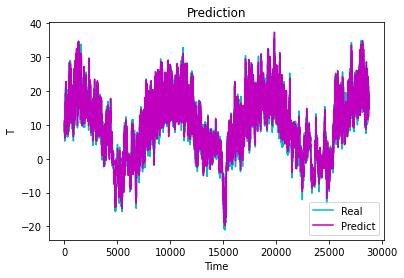

0.966580459961591


In [22]:
plt.plot(yTest, 'c-', label='Real')
plt.plot(yPredictes, 'm-', label='Predict')
# plt.plot(data_original, color='red', label='Real')
# plt.plot(range(len(y_train)),yPredicts, color='blue', label='Predict')
plt.title(label='Prediction')
plt.xlabel(xlabel='Time')
plt.ylabel(ylabel='T')
plt.legend()
plt.show()

r2 = r2_score(yTest, yPredictes)
r2_value['RNN'] = r2
print(r2)

# <font color=purple>Dense</font>

In [23]:
timestep = dense_width

In [24]:
xTrainSet = dt_nor[:training_num]
yTrainSet = dt_nor[1:training_num+1]

In [25]:
xTrain = []
for i in range(timestep, training_num):
  xTrain.append(xTrainSet[i-timestep : i])
xTrain = np.array(xTrain)
#xTrain = np.squeeze(xTrain)
xTrain = np.reshape(xTrain, (xTrain.shape[0], xTrain.shape[1], 1))
print(xTrain.shape)

yTrain = []
for i in range(timestep, training_num):
  yTrain.append(yTrainSet[i])
yTrain = np.array(yTrain)
#yTrain = np.reshape(yTrain, (yTrain.shape[0], 1))
print(yTrain.shape)

(11969, 31, 1)
(11969, 1)


In [26]:
model_dense = Sequential()
model_dense.add(Input(shape = (xTrain.shape[1])))
model_dense.add(Flatten())
model_dense.add(Dense(128, activation='relu'))
model_dense.add(Dense(64, activation='relu'))
model_dense.add(Dense(1))

model_dense.summary()

Model: "sequential_139"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_92 (Flatten)         (None, 31)                0         
_________________________________________________________________
dense_277 (Dense)            (None, 128)               4096      
_________________________________________________________________
dense_278 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_279 (Dense)            (None, 1)                 65        
Total params: 12,417
Trainable params: 12,417
Non-trainable params: 0
_________________________________________________________________


In [27]:
model_dense.compile(optimizer = 'adam',
          loss = 'mean_squared_error',
          metrics = [tf.metrics.MeanAbsoluteError()])
model_dense.fit(x = xTrain, y = yTrain, epochs = epoch, batch_size = batch_size)

Epoch 1/10
60/60 [==============================] - 0s 2ms/step - loss: 0.0367 - mean_absolute_error: 0.1341
Epoch 2/10
60/60 [==============================] - 0s 2ms/step - loss: 0.0011 - mean_absolute_error: 0.0255
Epoch 3/10
60/60 [==============================] - 0s 2ms/step - loss: 8.4854e-04 - mean_absolute_error: 0.0222
Epoch 4/10
60/60 [==============================] - 0s 2ms/step - loss: 7.3950e-04 - mean_absolute_error: 0.0204
Epoch 5/10
60/60 [==============================] - 0s 2ms/step - loss: 6.8657e-04 - mean_absolute_error: 0.0195
Epoch 6/10
60/60 [==============================] - 0s 2ms/step - loss: 6.4759e-04 - mean_absolute_error: 0.0188
Epoch 7/10
60/60 [==============================] - 0s 2ms/step - loss: 5.9562e-04 - mean_absolute_error: 0.0181
Epoch 8/10
60/60 [==============================] - 0s 2ms/step - loss: 5.7174e-04 - mean_absolute_error: 0.0177
Epoch 9/10
60/60 [==============================] - 0s 2ms/step - loss: 5.9664e-04 - mean_absolute_error

# <font color=purple>Test model's accuracy by r2_score (1200 days)</font>

In [28]:
xTestSet = dt_nor[training_num : 40800-2]
xTestSet = np.array(xTestSet)

yTestSet = dt_nor[training_num+1 : 40800-1]
yTestSet = np.array(yTestSet)

In [29]:
xTest = []
for i in range(timestep, len(xTestSet)):
    xTest.append(xTestSet[i-timestep : i])
xTest = np.array(xTest)
#xTest = np.squeeze(xTest)

yTest = []
for i in range(timestep, len(xTestSet)):
    yTest.append(yTestSet[i])
yTest = np.array(yTest)
yTest = sc.inverse_transform(yTest)
len(xTest)

28767

In [30]:
yTest.shape

(28767, 1)

In [31]:
yPredictes = model_dense.predict(x=xTest)
yPredictes = sc.inverse_transform(yPredictes)
yPredictes

array([[10.05247 ],
       [13.334333],
       [14.62565 ],
       ...,
       [17.424633],
       [16.384659],
       [15.441449]], dtype=float32)

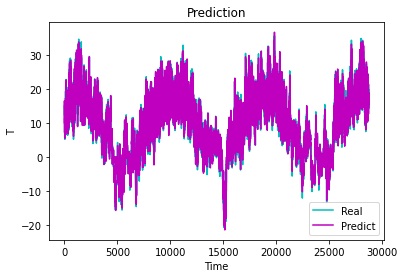

0.9754810370866053


In [32]:
plt.plot(yTest, 'c-', label='Real')
plt.plot(yPredictes, 'm-', label='Predict')
# plt.plot(data_original, color='red', label='Real')
# plt.plot(range(len(y_train)),yPredicts, color='blue', label='Predict')
plt.title(label='Prediction')
plt.xlabel(xlabel='Time')
plt.ylabel(ylabel='T')
plt.legend()
plt.show()

r2 = r2_score(yTest, yPredictes)
r2_value['Dense'] = r2
print(r2)

# <font color=purple>Cnn</font>

In [33]:
timestep = cnn_width

In [34]:
xTrainSet = dt_nor[:training_num]
yTrainSet = dt_nor[1:training_num+1]

In [35]:
xTrain = []
for i in range(timestep, training_num):
  xTrain.append(xTrainSet[i-timestep : i])
xTrain = np.array(xTrain)
# xTrain = np.squeeze(xTrain)
xTrain = np.reshape(xTrain, (xTrain.shape[0], xTrain.shape[1], 1))
print(xTrain.shape)

yTrain = []
for i in range(timestep, training_num):
  yTrain.append(yTrainSet[i])
yTrain = np.array(yTrain)
#yTrain = np.reshape(yTrain, (yTrain.shape[0], 1))
print(yTrain.shape)

(11975, 25, 1)
(11975, 1)


In [36]:
conv_width = 3
model_cnn = Sequential()
model_cnn.add(Conv1D(64, kernel_size=(conv_width),  input_shape = (xTrain.shape[1],1), activation='relu'))
model_cnn.add(Conv1D(32, kernel_size=(conv_width), activation='relu'))
model_cnn.add(Flatten())
model_cnn.add(Dense(32, activation='relu'))
model_cnn.add(Dense(1))

model_cnn.summary()

Model: "sequential_140"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_92 (Conv1D)           (None, 23, 64)            256       
_________________________________________________________________
conv1d_93 (Conv1D)           (None, 21, 32)            6176      
_________________________________________________________________
flatten_93 (Flatten)         (None, 672)               0         
_________________________________________________________________
dense_280 (Dense)            (None, 32)                21536     
_________________________________________________________________
dense_281 (Dense)            (None, 1)                 33        
Total params: 28,001
Trainable params: 28,001
Non-trainable params: 0
_________________________________________________________________


In [37]:
model_cnn.compile(optimizer = 'adam',
          loss = 'mean_squared_error',
          metrics = [tf.metrics.MeanAbsoluteError()])
model_cnn.fit(x = xTrain, y = yTrain, epochs = epoch, batch_size = batch_size)

Epoch 1/10
60/60 [==============================] - 1s 3ms/step - loss: 0.0913 - mean_absolute_error: 0.2289
Epoch 2/10
60/60 [==============================] - 0s 3ms/step - loss: 0.0034 - mean_absolute_error: 0.0453
Epoch 3/10
60/60 [==============================] - 0s 2ms/step - loss: 0.0016 - mean_absolute_error: 0.0305
Epoch 4/10
60/60 [==============================] - 0s 2ms/step - loss: 0.0012 - mean_absolute_error: 0.0267
Epoch 5/10
60/60 [==============================] - 0s 2ms/step - loss: 0.0010 - mean_absolute_error: 0.0244
Epoch 6/10
60/60 [==============================] - 0s 2ms/step - loss: 9.7746e-04 - mean_absolute_error: 0.0235
Epoch 7/10
60/60 [==============================] - 0s 2ms/step - loss: 8.5505e-04 - mean_absolute_error: 0.0219
Epoch 8/10
60/60 [==============================] - 0s 3ms/step - loss: 7.4004e-04 - mean_absolute_error: 0.0205
Epoch 9/10
60/60 [==============================] - 0s 2ms/step - loss: 6.1827e-04 - mean_absolute_error: 0.0185
Epo

# <font color=purple>Test model's accuracy by r2_score (1200 days)</font>

In [38]:
xTestSet = dt_nor[training_num : 40800-2]
xTestSet = np.array(xTestSet)

yTestSet = dt_nor[training_num+1 : 40800-1]
yTestSet = np.array(yTestSet)

In [39]:
xTest = []
for i in range(timestep, len(xTestSet)):
    xTest.append(xTestSet[i-timestep : i])
xTest = np.array(xTest)
# xTest = np.squeeze(xTest)

yTest = []
for i in range(timestep, len(xTestSet)):
    yTest.append(yTestSet[i])
yTest = np.array(yTest)
yTest = sc.inverse_transform(yTest)
len(xTest)

28773

In [40]:
yPredictes = model_cnn.predict(x=xTest)
yPredictes = sc.inverse_transform(yPredictes)
yPredictes.shape

(28773, 1)

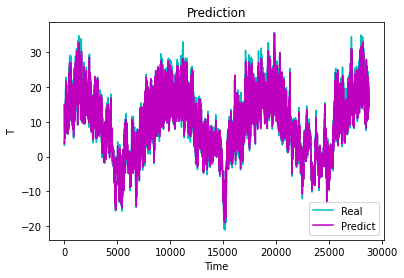

0.970434208330225


In [41]:
plt.plot(yTest, 'c-', label='Real')
plt.plot(yPredictes, 'm-', label='Predict')
# plt.plot(data_original, color='red', label='Real')
# plt.plot(range(len(y_train)),yPredicts, color='blue', label='Predict')
plt.title(label='Prediction')
plt.xlabel(xlabel='Time')
plt.ylabel(ylabel='T')
plt.legend()
plt.show()

r2 = r2_score(yTest, yPredictes)
r2_value['CNN'] = r2
print(r2)

# <font color=purple>Compare</font>

In [42]:
r2_value

{'CNN': 0.970434208330225,
 'Dense': 0.9754810370866053,
 'RNN': 0.966580459961591}

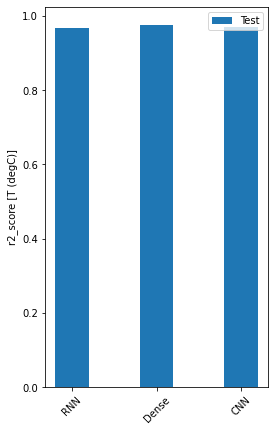

In [43]:
x = np.arange(3)
width = 0.2

val_r2 = r2_value.values()

plt.figure(figsize=(4,7))
plt.ylabel('r2_score [T (degC)]')
plt.bar(x , val_r2, 0.4, label='Test')
plt.xticks(ticks=x, labels=r2_value.keys(), rotation=45)
_ = plt.legend()

# <font color=purple>Use predict data to predict future</font>

# <font color=purple>Rnn</fnt>

In [44]:
# Take last 24 hours to predict
Predict_hours = 24

xPred = dt_nor[-Predict_hours-rnn_width:-Predict_hours]
xPred = np.array(xPred)
xPred_in = sc.inverse_transform(xPred)
xPred = np.reshape(xPred, (xPred.shape[1], xPred.shape[0], 1))

yFutureTest = dt_nor[-Predict_hours:]
yFutureTest = np.array(yFutureTest)
yFutureTest = sc.inverse_transform(yFutureTest)

real = []
real = np.append(xPred_in, yFutureTest, axis = 0)

In [45]:
xPred.shape

(1, 42, 1)

In [46]:
def PredFuture_rnn(xPred):
  yPred = model_rnn.predict(x=xPred)
  yPred = np.reshape(yPred, (1, 1, 1))
  data = np.append(xPred, yPred, axis = 1)
  data = data[:, -(rnn_width):, :]
  return data

yModelPred = []
for i in range (Predict_hours):
  xPred = PredFuture_rnn(xPred)
  yModelPred.append(xPred[0][-1])

In [47]:
yModelPred = np.array(yModelPred)
yModelPred = sc.inverse_transform(yModelPred)

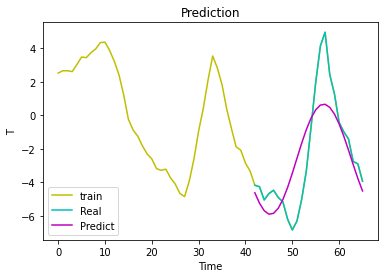

0.6429095118313762


In [48]:
plt.plot(real, 'y-', label='train')
plt.plot(range(rnn_width, Predict_hours + rnn_width), yFutureTest, 'c-', label='Real')
plt.plot(range(rnn_width, Predict_hours + rnn_width), yModelPred, 'm-', label='Predict')
plt.title(label='Prediction')
plt.xlabel(xlabel='Time')
plt.ylabel(ylabel='T')
plt.legend()
plt.show()

r2_future = {}
r2 = r2_score(yFutureTest, yModelPred)
r2_future['RNN'] = r2
print(r2)

# <font color=purple>Cnn</font>

In [49]:
# Take last 24 hours to predict
Predict_hours = 24

xPred = dt_nor[-Predict_hours-cnn_width:-Predict_hours]
xPred = np.array(xPred)
xPred_in = sc.inverse_transform(xPred)
# #xPred = np.reshape(xPred, (1,xPred.shape[0],xPred.shape[1]))
xPred = np.reshape(xPred, (xPred.shape[1], xPred.shape[0], 1))

yFutureTest = dt_nor[-Predict_hours:]
yFutureTest = np.array(yFutureTest)
yFutureTest = sc.inverse_transform(yFutureTest)

real = []
real = np.append(xPred_in, yFutureTest, axis = 0)

In [50]:
def PredFuture_cnn(xPred):
  yPred = model_cnn.predict(xPred)
  yPred = np.reshape(yPred, (1, 1, 1))
  data = np.append(xPred, yPred, axis = 1)
  data = data[:, -(cnn_width):, :]
  return data

yModelPred = []
for i in range (Predict_hours):
  xPred = PredFuture_cnn(xPred)
  yModelPred.append(xPred[0][-1])

In [51]:
yModelPred = np.array(yModelPred)
yModelPred = sc.inverse_transform(yModelPred)

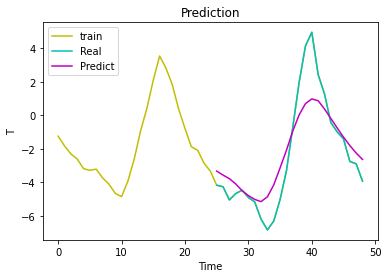

0.7851424365003093


In [52]:
plt.plot(real, 'y-', label='train')
plt.plot(range(cnn_width, Predict_hours + cnn_width), yFutureTest, 'c-', label='Real')
plt.plot(range(cnn_width, Predict_hours + cnn_width), yModelPred, 'm-', label='Predict')
plt.title(label='Prediction')
plt.xlabel(xlabel='Time')
plt.ylabel(ylabel='T')
plt.legend()
plt.show()

r2 = r2_score(yFutureTest, yModelPred)
r2_future['CNN'] = r2
print(r2)

# <font color=purple>Dense</font>

In [53]:
# Take last 24 hours to predict
Predict_hours = 24

xPred = dt_nor[-Predict_hours-dense_width:-Predict_hours]
xPred = np.array(xPred)
xPred_in = sc.inverse_transform(xPred)
# #xPred = np.reshape(xPred, (1,xPred.shape[0],xPred.shape[1]))
xPred = np.reshape(xPred, (xPred.shape[1], xPred.shape[0], 1))

yFutureTest = dt_nor[-Predict_hours:]
yFutureTest = np.array(yFutureTest)
yFutureTest = sc.inverse_transform(yFutureTest)

real = []
real = np.append(xPred_in, yFutureTest, axis = 0)

In [54]:
def PredFuture_dense(xPred):
  yPred = model_dense.predict(xPred)
  yPred = np.reshape(yPred, (1, 1, 1))
  data = np.append(xPred, yPred, axis = 1)
  data = data[:, -(dense_width):, :]
  return data

yModelPred = []
for i in range (Predict_hours):
  xPred = PredFuture_dense(xPred)
  yModelPred.append(xPred[0][-1])

In [55]:
yModelPred = np.array(yModelPred)
yModelPred = sc.inverse_transform(yModelPred)

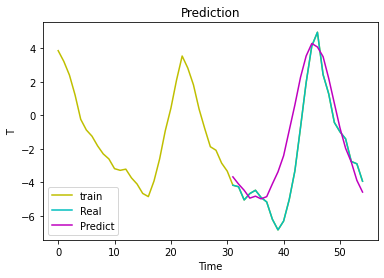

0.682133078239662


In [56]:
plt.plot(real, 'y-', label='train')
plt.plot(range(dense_width, Predict_hours + dense_width), yFutureTest, 'c-', label='Real')
plt.plot(range(dense_width, Predict_hours + dense_width), yModelPred, 'm-', label='Predict')
plt.title(label='Prediction')
plt.xlabel(xlabel='Time')
plt.ylabel(ylabel='T')
plt.legend()
plt.show()

r2 = r2_score(yFutureTest, yModelPred)
r2_future['Dense'] = r2
print(r2)

# <font color=purple>Compare</font>

In [57]:
r2_future

{'CNN': 0.7851424365003093,
 'Dense': 0.682133078239662,
 'RNN': 0.6429095118313762}

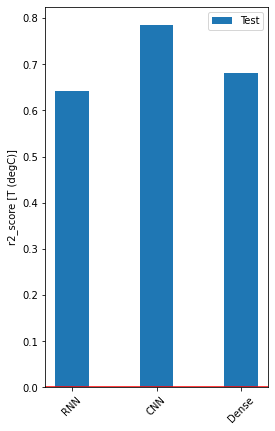

In [58]:
x = np.arange(3)
width = 0.2

val_r2 = r2_future.values()

plt.figure(figsize=(4,7))
plt.ylabel('r2_score [T (degC)]')
plt.axhline(0, color= 'r')
plt.bar(x , val_r2, 0.4, label='Test')
plt.xticks(ticks=x, labels=r2_future.keys(), rotation=45)
_ = plt.legend()